# Import library

In [1]:
import numpy as np
import pandas as pd
import os
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from scipy import fftpack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

from sklearn.svm import NuSVR, SVR
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression

import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from scipy.signal import butter
from scipy import signal
from sklearn.kernel_ridge import KernelRidge
from itertools import product
import pywt 

from tsfresh.feature_extraction import feature_calculators

import timeit
import multiprocessing as mp

from IPython.display import HTML

from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, CuDNNGRU
from keras.optimizers import adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.engine.input_layer import Input
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Some constant and utlity

In [2]:
def printLog(string):
    print(string)
    string = 'echo ' + str(string) + '\n'
    os.system(string)

PATH = '../input/'
isPrivateDatasetInclude = False

if os.path.isfile('../input/train.csv') == False:
    PATH = '../input/LANL-Earthquake-Prediction'
    isPrivateDatasetInclude = True
    
FOLDER_PATH_TEST = os.path.join(PATH, 'test/')
FILE_PATH_TRAIN = os.path.join(PATH, 'train.csv')
FILE_PATH_SUBMISSION = os.path.join(PATH, 'sample_submission.csv')
printLog('file/folder check ' + PATH + '  : ' + str(os.path.isdir(PATH)))
printLog('file/folder check ' + FOLDER_PATH_TEST + '  : ' + str(os.path.isdir(FOLDER_PATH_TEST)))
printLog('file/folder check ' + FILE_PATH_TRAIN + '  : ' + str(os.path.isfile(FILE_PATH_TRAIN)))
printLog('file/folder check ' + FILE_PATH_SUBMISSION + '  : ' + str(os.path.isfile(FILE_PATH_SUBMISSION)))
pd.options.display.precision = 20
segment_size = 150000

file/folder check ../input/LANL-Earthquake-Prediction  : True
file/folder check ../input/LANL-Earthquake-Prediction/test/  : True
file/folder check ../input/LANL-Earthquake-Prediction/train.csv  : True
file/folder check ../input/LANL-Earthquake-Prediction/sample_submission.csv  : True


# denoise the signal
* all this is referenced from [here](https://www.kaggle.com/tarunpaparaju/lanl-earthquake-prediction-signal-denoising)

In [3]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, SAMPLE_RATE=4000000):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)
    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

# Featrues extraction

In [4]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

def dataTransform_FFT(data):
    fft = fftpack.rfft(data)
    freq = np.fft.fftfreq(data.size)
    return freq, fft

def features(x, y, seg_id):
    feature_dict = dict()
    feature_dict['target'] = y
    feature_dict['seg_id'] = seg_id

    # create features here

    # lists with parameters to iterate over them
    percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
    hann_windows = [50, 150, 1500, 15000]
    spans = [300, 3000, 30000, 50000]
    windows = [10, 50, 100, 500, 1000, 10000]
    borders = list(range(-4000, 4001, 1000))
    peaks = [10, 20, 50, 100]
    coefs = [1, 5, 10, 50, 100]
    lags = [10, 100, 1000, 10000]
    autocorr_lags = [5, 10, 50, 100, 500, 1000, 5000, 10000]

    # basic stats
    feature_dict['mean'] = x.mean()
    feature_dict['std'] = x.std()
    feature_dict['max'] = x.max()
    feature_dict['min'] = x.min()

    # basic stats on absolute values
    feature_dict['mean_change_abs'] = np.mean(np.diff(x))
    feature_dict['abs_max'] = np.abs(x).max()
    feature_dict['abs_mean'] = np.abs(x).mean()
    feature_dict['abs_std'] = np.abs(x).std()

    # geometric and harminic means
    feature_dict['hmean'] = stats.hmean(np.abs(x[np.nonzero(x)[0]]))
    feature_dict['gmean'] = stats.gmean(np.abs(x[np.nonzero(x)[0]])) 

    # k-statistic and moments
    for i in range(1, 5):
        feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
        feature_dict[f'moment_{i}'] = stats.moment(x, i)

    for i in [1, 2]:
        feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)

    # aggregations on various slices of data
    for agg_type, slice_length, direction in product(['std', 'min', 'max', 'mean'], [1000, 10000, 50000], ['first', 'last']):
        if direction == 'first':
            feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[:slice_length].agg(agg_type)
        elif direction == 'last':
            feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[-slice_length:].agg(agg_type)

    feature_dict['max_to_min'] = x.max() / np.abs(x.min())
    feature_dict['max_to_min_diff'] = x.max() - np.abs(x.min())
    feature_dict['count_big'] = len(x[np.abs(x) > 500])
    feature_dict['sum'] = x.sum()

    feature_dict['mean_change_rate'] = calc_change_rate(x)
    # calc_change_rate on slices of data
    for slice_length, direction in product([1000, 10000, 50000], ['first', 'last']):
        if direction == 'first':
            feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
        elif direction == 'last':
            feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])

    # percentiles on original and absolute values
    for p in percentiles:
        feature_dict[f'percentile_{p}'] = np.percentile(x, p)
        feature_dict[f'abs_percentile_{p}'] = np.percentile(np.abs(x), p)

    feature_dict['trend'] = add_trend_feature(x)
    feature_dict['abs_trend'] = add_trend_feature(x, abs_values=True)

    feature_dict['mad'] = x.mad()
    feature_dict['kurt'] = x.kurtosis()
    feature_dict['skew'] = x.skew()
    feature_dict['med'] = x.median()

    feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()

    for hw in hann_windows:
        feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()

    feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()

    # exponential rolling statistics
    ewma = pd.Series.ewm
    for s in spans:
        feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x, span=s).mean(skipna=True)).mean(skipna=True)
        feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x, span=s).mean(skipna=True)).std(skipna=True)
        feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x, span=s).std(skipna=True)).mean(skipna=True)
        feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x, span=s).std(skipna=True)).std(skipna=True)

    feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
    feature_dict['ave10'] = stats.trim_mean(x, 0.1)

    for slice_length, threshold in product([50000, 100000, 150000],
                                                 [5, 10, 20, 50, 100]):
        feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
        feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()
        
    feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
    feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

    for i, j in zip(borders, borders[1:]):
        feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)

    for autocorr_lag in autocorr_lags:
        feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
        feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

    for p in percentiles:
        feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

    feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)

    for peak in peaks:
        feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)

    for c in coefs:
        feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
        feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  

    # statistics on rolling windows of various sizes
    for w in windows:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values

        feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
        feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
        feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
        feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()

        for p in percentiles:
            feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)

        feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
        feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

        feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
        feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
        feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
        feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()

        for p in percentiles:
            feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

        feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
        feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()       

    return feature_dict

def features_fft(x):
    feature_fft_dict = dict()
    ### https://www.kaggle.com/vettejeep/masters-final-project-model-lb-1-392/
    realFFT = np.real(x)
    imagFFT = np.imag(x)
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    phzFFT = np.arctan(imagFFT / realFFT)
    phzFFT[phzFFT == -np.inf] = -np.pi / 2.0
    phzFFT[phzFFT == np.inf] = np.pi / 2.0
    phzFFT = np.nan_to_num(phzFFT)
    FREQ_STEP = 2500
    freq_bands = [x for x in range(0, 20000, FREQ_STEP)]
    for freq in freq_bands:
        feature_fft_dict[f'FFT_Mag_01q_{freq}'] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.01)
        feature_fft_dict[f'FFT_Mag_10q_{freq}'] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.1)
        feature_fft_dict[f'FFT_Mag_90q_{freq}'] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.9)
        feature_fft_dict[f'FFT_Mag_99q_{freq}'] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.99)
        feature_fft_dict[f'FFT_Mag_mean_{freq}'] = np.mean(magFFT[freq: freq + FREQ_STEP])
        feature_fft_dict[f'FFT_Mag_std_{freq}'] = np.std(magFFT[freq: freq + FREQ_STEP])
        feature_fft_dict[f'FFT_Mag_max_{freq}'] = np.max(magFFT[freq: freq + FREQ_STEP])
        feature_fft_dict[f'FFT_Phz_mean_{freq}'] = np.mean(phzFFT[freq: freq + FREQ_STEP])
        feature_fft_dict[f'FFT_Phz_std_{freq}'] = np.std(phzFFT[freq: freq + FREQ_STEP])
    feature_fft_dict['FFT_Rmean'] = realFFT.mean()
    feature_fft_dict['FFT_Rstd'] = realFFT.std()
    feature_fft_dict['FFT_Rmax'] = realFFT.max()
    feature_fft_dict['FFT_Rmin'] = realFFT.min()
    feature_fft_dict['FFT_Imean'] = imagFFT.mean()
    feature_fft_dict['FFT_Istd'] = imagFFT.std()
    feature_fft_dict['FFT_Imax'] = imagFFT.max()
    feature_fft_dict['FFT_Imin'] = imagFFT.min()
    feature_fft_dict['FFT_Rmean_first_6000'] = realFFT[:6000].mean()
    feature_fft_dict['FFT_Rstd__first_6000'] = realFFT[:6000].std()
    feature_fft_dict['FFT_Rmax_first_6000'] = realFFT[:6000].max()
    feature_fft_dict['FFT_Rmin_first_6000'] = realFFT[:6000].min()
    feature_fft_dict['FFT_Rmean_first_18000'] = realFFT[:18000].mean()
    feature_fft_dict['FFT_Rstd_first_18000'] = realFFT[:18000].std()
    feature_fft_dict['FFT_Rmax_first_18000'] = realFFT[:18000].max()
    feature_fft_dict['FFT_Rmin_first_18000'] = realFFT[:18000].min()
    ###
    temp_Xs, temp_Ys = dataTransform_FFT(x)  # the Xs should be amplitude of the wave and Ys is the frequency
    idxs = np.where(temp_Xs != 0)
    # use those index to get what we want
    fft_Xs = temp_Xs[idxs]
    fft_Ys = temp_Ys[idxs]
    # assume that interval 0~0.2 is all matter
    # and according to experiment, the negatives' abs_mean and abs_std of different segment are not significantly different
    sections = np.r_[np.arange(-0.5+0.02, 0.5, 0.02)]
    for idx, item in enumerate(sections):
        up_bound = item
        indexes = np.where(fft_Xs < up_bound)
        amplitude = fft_Ys[indexes]
        amplitude_abs = amplitude
        np.abs(amplitude, out=amplitude_abs)   ## use the 'out' will process a lot faster according to Stackoverflow
        feature_fft_dict[f'fft_amplitude_abs_avg_{up_bound}_percentile_0_100'] = amplitude_abs.mean()
        feature_fft_dict[f'fft_amplitude_abs_max_{up_bound}_percentile_0_100'] = amplitude_abs.max()
        feature_fft_dict[f'fft_amplitude_abs_min_{up_bound}_percentile_0_100'] = amplitude_abs.min()
        feature_fft_dict[f'fft_amplitude_abs_sum_{up_bound}_percentile_0_100'] = amplitude_abs.sum()
        feature_fft_dict[f'fft_amplitude_abs_std_{up_bound}_percentile_0_100'] = amplitude_abs.std()
#         percentiles = [0, 12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100]
#         for i in range(7):
#             sub_bound_1 = percentiles[i]
#             sub_bound_2 = percentiles[i+1]
#             temp = amplitude_abs[np.where(np.logical_and(amplitude_abs >= np.percentile(amplitude_abs, sub_bound_1), amplitude_abs < np.percentile(amplitude_abs, sub_bound_2)))]
#             feature_fft_dict[f'fft_amplitude_abs_avg_{up_bound}_percentile_{sub_bound_1}_{sub_bound_2}'] = temp.mean()
# #             feature_fft_dict[f'fft_amplitude_abs_max_{up_bound}_percentile_{sub_bound_1}_{sub_bound_2}'] = temp.max()
# #             feature_fft_dict[f'fft_amplitude_abs_min_{up_bound}_percentile_{sub_bound_1}_{sub_bound_2}'] = temp.min()
# #             feature_fft_dict[f'fft_amplitude_abs_sum_{up_bound}_percentile_{sub_bound_1}_{sub_bound_2}'] = temp.sum()
#             del temp
#         temp = amplitude_abs[np.where(amplitude_abs >= np.percentile(amplitude_abs, percentiles[7]))]
#         feature_fft_dict[f'fft_amplitude_abs_avg_{up_bound}_percentile_87.5_100'] = temp.mean()
# #         feature_fft_dict[f'fft_amplitude_abs_max_{up_bound}_percentile_87.5_100'] = temp.max()
# #         feature_fft_dict[f'fft_amplitude_abs_min_{up_bound}_percentile_87.5_100'] = temp.min()
# #         feature_fft_dict[f'fft_amplitude_abs_sum_{up_bound}_percentile_87.5_100'] = temp.sum()
#         del temp
        # beacuse we only use the upper bound, so the array needs to update
        fft_Ys = amplitude
        fft_Xs = fft_Xs[indexes]
    return feature_fft_dict

def get_features(x, y, seg_id):
    x = pd.Series(denoise_signal(high_pass_filter(x, low_cutoff=10000, SAMPLE_RATE=4000000), wavelet='haar', level=1))
    main_dict = features(x, y, seg_id)
    fft_dict = features_fft(x)
    return {**main_dict, **fft_dict}

# Load the data and retrieve features

In [5]:
logStep = 5

def read_chunks(data_set_type, pool):
    feature_list = []
    start = timeit.default_timer()
    if data_set_type == 'train':
        total = int(629145481 / segment_size + 1)
        data_chunk = pd.read_csv(FILE_PATH_TRAIN, dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64}, chunksize=segment_size)
#         data_chunk = pd.read_csv(FILE_PATH_TRAIN, dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64}, chunksize=segment_size, nrows=150000*5)
        for idx, chunk in enumerate(data_chunk):
            x = chunk.acoustic_data.values
            y = chunk.time_to_failure.values[-1]
            del chunk
            res = pool.apply_async(get_features, [x, y, idx])
            row = res.get()
            del x
            del y
            feature_list.append(row)
            end = timeit.default_timer()
            used_total = end - start
            left = total - idx
            if idx%logStep == 0:
                printLog('train data progress : {0:4d}/{1:4d}, used time: {2:9.4f}, eta:{3:9.4f}'.format(idx, total, used_total, used_total/(idx+1)*left))
    elif data_set_type == 'test':
        submission = pd.read_csv(FILE_PATH_SUBMISSION)
#         submission = submission[:5]
        total = int(len(submission))
        for idx, seg_id in enumerate(submission.seg_id.values):
            file_name = FOLDER_PATH_TEST + seg_id + '.csv'
            chunk = pd.read_csv(file_name, dtype={'acoustic_data': np.float64})
            x = chunk.acoustic_data.values[-segment_size:]
            del chunk
            res = pool.apply_async(get_features, [x, -1, seg_id])
            row = res.get()
            del x
            feature_list.append(row)
            end = timeit.default_timer()
            used_total = end - start
            left = total - idx
            if idx%logStep == 0:
                printLog('test data progress : {0:4d}/{1:4d}, used time: {2:9.4f}, eta: {3:9.4f}'.format(idx, total, used_total, used_total/(idx+1)*left))     
    return feature_list

train_data = pd.DataFrame()
test_data = pd.DataFrame()
X = pd.DataFrame()
X_test = pd.DataFrame()
test_segs = []
y = []

if os.path.isdir('../input/0520test'):
    train_data = pd.read_csv('../input/0520test/train_data_0530.csv')
    train_data.drop(['Unnamed: 0'], inplace=True, axis=1)
    test_data = pd.read_csv('../input/0520test/test_data_0530.csv')
    test_data.drop(['Unnamed: 0'], inplace=True, axis=1)
    X = train_data.drop(['target', 'seg_id'], axis=1)
    X_test = test_data.drop(['target', 'seg_id'], axis=1)
    test_segs = test_data.seg_id
    y = train_data.target
    del train_data, test_data
else:
    pool = mp.Pool(4)
    train_data = pd.DataFrame(read_chunks('train', pool))
    X = train_data.drop(['target', 'seg_id'], axis=1)
    y = train_data.target
    train_data.to_csv('train_data')
    del train_data
    printLog('training data done preparing.')
    
    test_data = pd.DataFrame(read_chunks('test', pool))
    X_test = test_data.drop(['target', 'seg_id'], axis=1)
    test_segs = test_data.seg_id
    test_data.to_csv('test_data')
    del test_data
    printLog('testing data done preparing.')
    del pool

# clean the data

In [6]:
means_dict = {}
for col in X.columns:
    if X[col].isnull().any():
        print(col)
        mean_value = X.loc[X[col] != -np.inf, col].mean()
        X.loc[X[col] == -np.inf, col] = mean_value
        X[col] = X[col].fillna(mean_value)
        means_dict[col] = mean_value
        
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

DATA_DIMENSION = X.values[0,:].size
printLog('total ' + str(DATA_DIMENSION) + ' of features are used.')

mean_change_rate_first_1000
mean_change_rate_first_10000
mean_change_rate_last_1000
mean_change_rate_last_10000
total 806 of features are used.


# define the train model

In [7]:
def get_model_MLP():
    model = Sequential()
    model.add(Dense(500, activation='relu', input_dim=DATA_DIMENSION))
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
#     model.summary()
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return model

def get_model_LGBM(params):
    return lgb.LGBMRegressor(**params, n_estimators=50000, n_jobs = -1)

def get_model_CNN():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(DATA_DIMENSION, 1)))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(64, 10, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(16, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
#     model.summary()
    return model

def get_model_RNN():
    model = Sequential()
    model.add(CuDNNGRU(48, input_shape=(DATA_DIMENSION, 1)))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss="mae")
#     model.summary()
    return model

## to visualize the status of each model during training

In [8]:
def plot_status_during_training(maes, modelName, figSubTitle, isScaleLog=False):
    min_mae = np.min(np.array(maes))
    min_mae_idx = maes.index(min_mae)
    min_mae = float(min_mae)
    plt.figure(figsize=(18, 8))
    if isScaleLog == True:
        plt.yscale('log')
    plt.xlabel('epoch')
    plt.ylabel('MAE')
    plt.title('MAE of every epoch on training model ' + modelName + '\n' + figSubTitle)
    plt.plot(np.array(maes), color='b', label='mean absolute error')
    plt.plot(min_mae_idx, min_mae, color='r', marker='x', label='minimum mean absolute error')
    plt.legend(loc='upper right')
    plt.annotate(f'{min_mae}', xy=(min_mae_idx, min_mae), xycoords='data', xytext=(5, 10), textcoords='offset points', color='r')

def train_model_on_only_first_fold(model_name, X, X_test, y, params=None):
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        if fold_n == 0:
            if type(X) == np.ndarray:
                X_train, X_valid = X[train_index], X[valid_index]
                y_train, y_valid = y[train_index], y[valid_index]
            else:
                X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
                y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            if model_name == 'LGBM':
                model = get_model_LGBM(params)
                model.fit(X_train, 
                          y_train, 
                          eval_set=[(X_valid, y_valid)], 
                          eval_metric='mae', 
                          eval_names=['val_maes'], 
                          verbose=500001, 
                          early_stopping_rounds=200)
                
                plot_status_during_training(model.evals_result_['val_maes']['l1'], 'LGBM', 'Training until validation scores don''t improve for 200 rounds')
            elif model_name == 'MLP':
                model = get_model_MLP()
                total_epochs = 500
                history = History()
                model.fit(np.array(X_train), 
                          np.array(y_train), 
                          batch_size=50, 
                          epochs=total_epochs, 
                          verbose=0, 
                          validation_data=(np.array(X_valid), np.array(y_valid)), 
                          callbacks=[history])
                
                plot_status_during_training(history.history['val_loss'], 'MLP', f'Training total {total_epochs} rounds', True)
                del model
                del history
            elif model_name == 'CNN':
                model = get_model_CNN()
                total_epochs = 500
                history = History()
                model.fit(np.expand_dims(X_train, axis=-1), 
                          y_train, 
                          batch_size=50, 
                          epochs=total_epochs, 
                          validation_data=(np.expand_dims(X_valid, axis=-1), y_valid), 
                          callbacks=[history], 
                          verbose=0)
                
                plot_status_during_training(history.history['val_loss'], 'CNN', f'Training total {total_epochs} rounds', True)
                del model
                del history
            elif model_name == 'RNN':
                model = get_model_RNN()
                total_epochs = 500
                history = History()
                es = EarlyStopping(monitor='val_loss', 
                                   mode='min', 
#                                    verbose=1, 
                                   patience=20)
                
                model.fit(np.expand_dims(X_train, axis=-1), 
                          y_train, 
                          batch_size=50, 
                          epochs=total_epochs, 
                          validation_data=(np.expand_dims(X_valid, axis=-1), y_valid), 
                          callbacks=[history, es], 
                          verbose=0)
                
                plot_status_during_training(history.history['val_loss'], 'RNN', f'Training total {total_epochs} rounds or until validation scores don''t improve for 20 rounds', True)
                del model
                del history
                
# train_model_on_only_first_fold('LGBM', X, X_test, y, param)
# train_model_on_only_first_fold('MLP', X, X_test, y)
# train_model_on_only_first_fold('CNN', X, X_test, y)
# train_model_on_only_first_fold('RNN', X, X_test, y)

In [9]:


def train_model(model_name, X, X_test, y, params=None):
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        printLog('Fold '+ str(fold_n) + ', started at '+ time.ctime())
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_name == 'LGBM':
            model = get_model_LGBM(params)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae', verbose=500001, early_stopping_rounds=200)
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        elif model_name == 'MLP':
            model = get_model_MLP()
            total_epochs = 500
            model.fit(np.array(X_train), np.array(y_train), batch_size=50, epochs=total_epochs, verbose=0, validation_data=(np.array(X_valid), np.array(y_valid)))
            y_pred_valid = model.predict(np.array(X_valid))
            y_pred = model.predict(np.array(X_test))
        elif model_name == 'CNN':
            model = get_model_CNN()
            total_epochs = 500
            model.fit(np.expand_dims(X_train, axis=-1), y_train, batch_size=50, epochs=total_epochs, validation_data=(np.expand_dims(X_valid, axis=-1), y_valid), verbose=0)
            y_pred_valid = model.predict(np.expand_dims(X_valid, axis=-1))
            y_pred = model.predict(np.expand_dims(X_test, axis=-1))
        elif model_name == 'RNN':
            model = get_model_RNN()
            total_epochs = 500
            es = EarlyStopping(monitor='val_loss', mode='min', patience=20)
            model.fit(np.expand_dims(X_train, axis=-1), y_train, batch_size=50, epochs=total_epochs, validation_data=(np.expand_dims(X_valid, axis=-1), y_valid), callbacks=[es], verbose=0)
            y_pred_valid = model.predict(np.expand_dims(X_valid, axis=-1))
            y_pred = model.predict(np.expand_dims(X_test, axis=-1))
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += np.array(y_pred).flatten()

    prediction /= n_fold
    printLog('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    return oof, prediction, scores

# Training process

## the parameters of LGBM model
* which the parameters is optimizes by Bayesian Optimization

In [10]:
param = {'num_leaves': int(8.60117018334198),
         'min_data_in_leaf': int(9.11677624705122), 
         'objective':'gamma',
         'max_depth': int(97.9089710230119),
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.214020483459169,
         "bagging_freq": 1,
         "bagging_fraction": 0.671889607360485,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 2.78980470884316,
         "verbosity": -1,
         'is_unbalance': bool(0.0559898786914926 >= 0.5)
        }

## to train each model and output the results
* which the approximately execute time is as follow
    * MLP
        * about 4 mins per fold
    * CNN
        * about 5 mins per fold
    * RNN
        * about 3 mins per fold (not include early stop)
    * LGBM
        * within 3 mins for all fold

In [11]:
printLog('using MLP model to train ...')
oof_mlp, prediction_mlp, scores_mlp = train_model('MLP', X, X_test, y)
printLog('MLP model training complete.')
printLog('using CNN model to train ...')
oof_cnn, prediction_cnn, scores_cnn = train_model('CNN', X, X_test, y)
printLog('CNN model training complete.')
printLog('using RNN model to train ...')
oof_rnn, prediction_rnn, scores_rnn = train_model('RNN', X, X_test, y)
printLog('RNN model training complete.')
printLog('using LGBM model to train ...')
oof_lgb, prediction_lgb, scores_lgb = train_model('LGBM', X, X_test, y, params=param)
printLog('LGBM model training complete.')

using MLP model to train ...
Fold 0, started at Wed Jun 19 14:13:52 2019
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Fold 1, started at Wed Jun 19 14:16:05 2019
Fold 2, started at Wed Jun 19 14:18:17 2019
Fold 3, started at Wed Jun 19 14:20:30 2019
Fold 4, started at Wed Jun 19 14:22:44 2019
CV mean score: 3.0391, std: 0.0505.
MLP model training complete.
using CNN model to train ...
Fold 0, started at Wed Jun 19 14:24:59 2019
Fold 1, started at Wed Jun 19 14:27:41 2019
Fold 2, started at Wed Jun 19 14:30:21 2019
Fold 3, started at Wed Jun 19 14:33:02 2019
Fold 4, started at Wed Jun 19 14:35:43 2019
CV mean score: 3.0393, std: 0.0505.
CNN model training complete.
using RNN model to train ...
Fold 0, started at Wed Jun 19 14:38:27 2019
Fold 1, started at Wed Jun 19 14:41:27 2019
Fold 2, started at W

# Plot the training result and compare them with train data

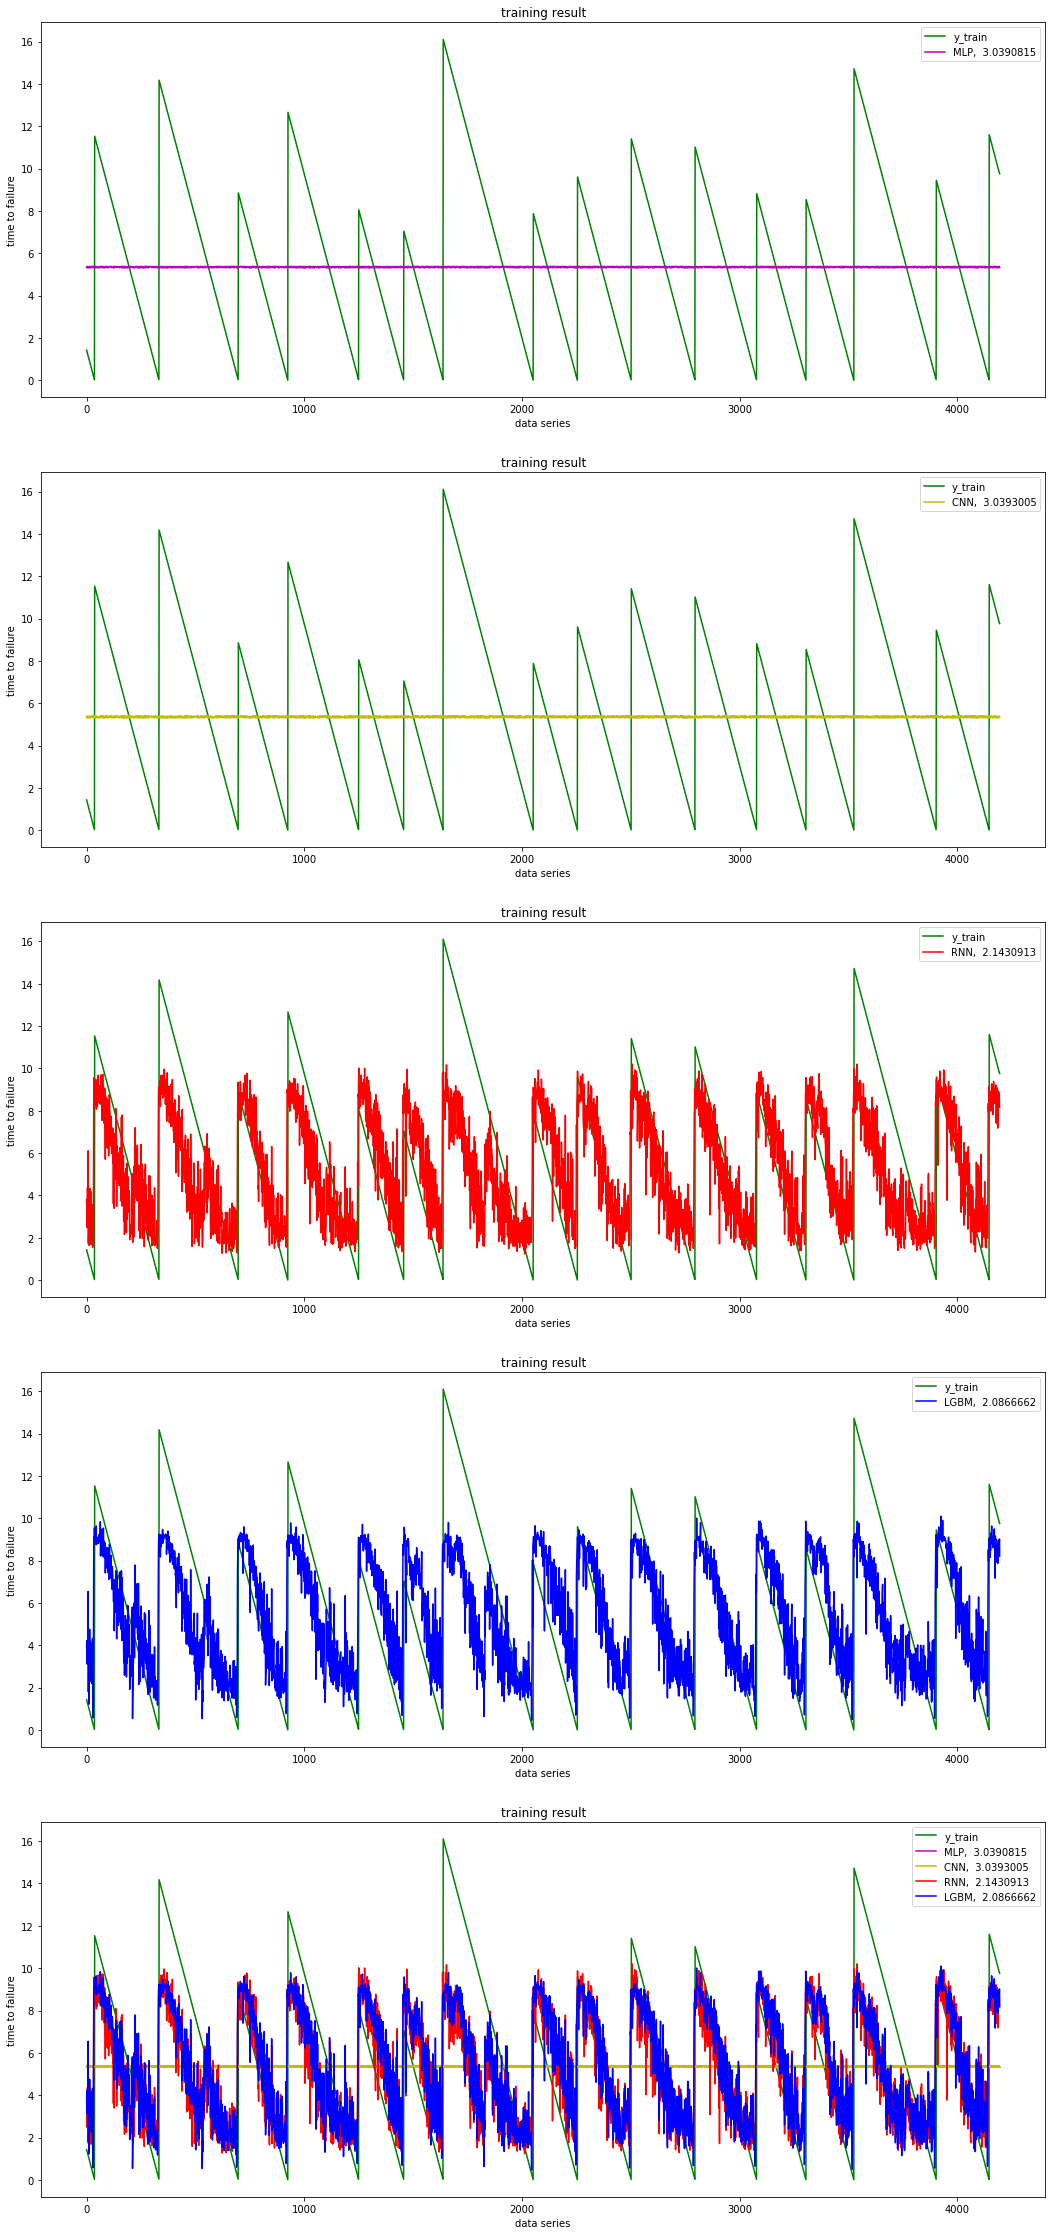

In [12]:
plt.figure(figsize=(18, 40))
plt.subplot(5,1,1)
plt.ylabel('time to failure')
plt.xlabel('data series')
plt.title('training result')
plt.plot(y, color='g', label='y_train')
plt.plot(oof_mlp, color='m', label=f'MLP, {np.mean(scores_mlp):10.8}')
plt.legend(loc='upper right')
plt.subplot(5,1,2)
plt.ylabel('time to failure')
plt.xlabel('data series')
plt.title('training result')
plt.plot(y, color='g', label='y_train')
plt.plot(oof_cnn, color='y', label=f'CNN, {np.mean(scores_cnn):10.8}')
plt.legend(loc='upper right')
plt.subplot(5,1,3)
plt.ylabel('time to failure')
plt.xlabel('data series')
plt.title('training result')
plt.plot(y, color='g', label='y_train')
plt.plot(oof_rnn, color='r', label=f'RNN, {np.mean(scores_rnn):10.8}')
plt.legend(loc='upper right')
plt.subplot(5,1,4)
plt.ylabel('time to failure')
plt.xlabel('data series')
plt.title('training result')
plt.plot(y, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label=f'LGBM, {np.mean(scores_lgb):10.8}')
plt.legend(loc='upper right')
plt.subplot(5,1,5)
plt.ylabel('time to failure')
plt.xlabel('data series')
plt.title('training result')
plt.plot(y, color='g', label='y_train')
plt.plot(oof_mlp, color='m', label=f'MLP, {np.mean(scores_mlp):10.8}')
plt.plot(oof_cnn, color='y', label=f'CNN, {np.mean(scores_cnn):10.8}')
plt.plot(oof_rnn, color='r', label=f'RNN, {np.mean(scores_rnn):10.8}')
plt.plot(oof_lgb, color='b', label=f'LGBM, {np.mean(scores_lgb):10.8}')
plt.legend(loc='upper right')

# Sumbit the result

In [13]:
printLog('submit training result ...')
submission = pd.read_csv(FILE_PATH_SUBMISSION, index_col='seg_id')
submission['time_to_failure'] = prediction_lgb
printLog(submission.head())
submission.to_csv('submission.csv')
printLog('submit result complete.')
printLog('all jobs done.')

submit training result ...
                   time_to_failure
seg_id                            
seg_00030f  3.81061396766019333526
seg_0012b5  5.32947413264866298732
seg_00184e  5.98630268469847326429
seg_003339  8.71023675284503084981
seg_0042cc  6.50766901167630162917
submit result complete.
all jobs done.
